# Spotify Song Prediction

##### Dependencies

In [133]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##### Loading the dataset

In [170]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


##### Dropping invalid and missing values

In [171]:
columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

# df = df[df['track_popularity'] < 15]

rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

# Assuming 'date' is a string column in the format 'YYYY-MM-DD'
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')
# new_df['month'] = pd.to_numeric(new_df['month'], errors='coerce', downcast='integer')
# new_df['day'] = pd.to_numeric(new_df['day'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())
# median_month = int(new_df['month'].median())
# median_day = int(new_df['day'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)
# new_df['month'] = new_df['month'].fillna(median_month).astype(int)
# new_df['day'] = new_df['day'].fillna(median_day).astype(int)

X = new_df.drop(['track_popularity', 'track_album_release_date', 'year', 'month', 'day'], axis=1)
# X.columns

X = pd.get_dummies(X, dtype=int)
X['year'] = new_df['year']
y = new_df['track_popularity']


In [172]:
# X.tail()
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subgenre_prog

In [137]:
df.iloc[3446]
X.iloc[3446]

danceability    0.630
energy          0.526
key             7.000
loudness       -9.121
mode            1.000
                ...  
day_27          0.000
day_28          0.000
day_29          0.000
day_30          0.000
day_31          0.000
Name: 3446, Length: 86, dtype: float64

##### Splitting the dataset

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

(array([3985.,  861.,  742.,  759.,  872.,  872., 1028., 1211., 1549.,
        1808., 1820., 1903., 1974., 1984., 2008., 1959., 1795., 1686.,
        1355., 1149.,  648.,  422.,  248.,  123.,   71.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <BarContainer object of 25 artists>)

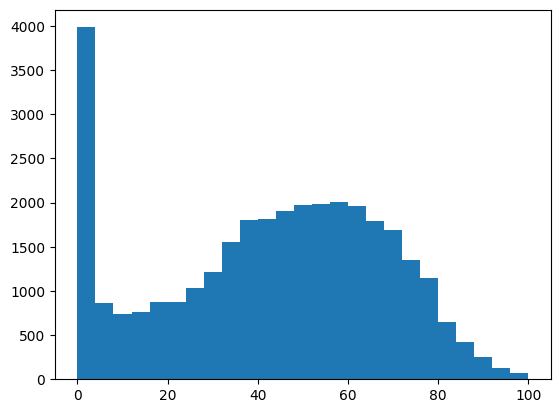

In [139]:
plt.hist(y, bins=25)

In [140]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
count,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,...,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000
mean,0.654869,0.698631,5.374604,-6.718909,0.565698,0.107071,0.175339,0.084750,0.190182,0.510577,...,0.028905,0.026285,0.025981,0.030245,0.027656,0.030885,0.026620,0.024854,0.023300,0.016752
std,0.145043,0.180900,3.611632,2.986570,0.495673,0.101314,0.219634,0.224233,0.154316,0.233132,...,0.167541,0.159985,0.159080,0.171263,0.163988,0.173007,0.160974,0.155682,0.150858,0.128343
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [174]:
print(X.columns)

numeric_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
dummy_feats = [feat for feat in X.columns if feat not in numeric_feats]

print(X[numeric_feats])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subgenre_prog

<Axes: >

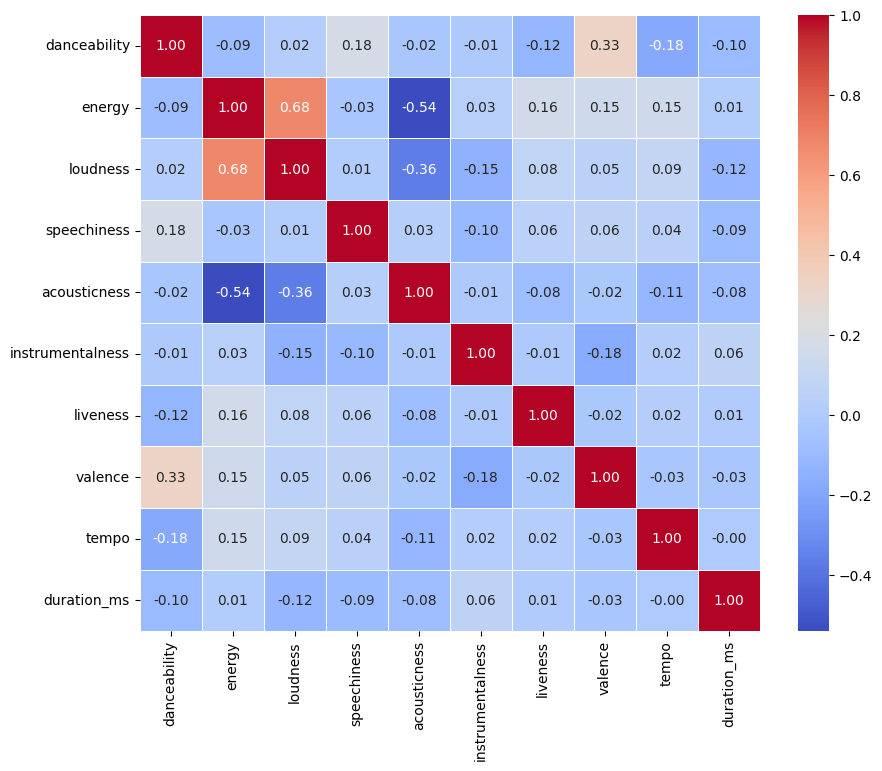

In [175]:
numeric_values = df[numeric_feats]
correlation_matrix = numeric_values.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [143]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - ((1 - r2) * (N - 1)) / (N - d - 1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res = pd.concat([pd.DataFrame(y_test.values),
                    pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse, mae, rmse, r2, r2_adj

##### Scaling the data

In [176]:
s = StandardScaler()
s.fit(X_train[numeric_feats])
X_train_std = s.transform(X_train[numeric_feats])
X_test_std = s.transform(X_test[numeric_feats])
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

X_train_std.columns = list(X.columns)
X_test_std.columns = list(X.columns)
X_train_std.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary,year
0,-1.475185,0.299901,0.885663,-0.623145,-0.478061,-0.378039,-1.057780,-1.100957,0.525789,0.565481,...,0,1,0,0,0,0,0,0,0,2016
1,0.352463,0.476752,0.081846,1.620841,-0.737502,-0.378039,-0.169845,-0.573133,1.456620,0.654139,...,0,0,0,0,0,1,0,0,0,2018
2,1.711131,-0.993323,-1.134759,1.976716,-0.666952,-0.373994,0.893085,0.366652,-0.718915,2.088656,...,0,0,0,0,0,1,0,0,0,1993
3,0.159353,-0.617514,-0.012228,3.093766,-0.761534,3.818733,2.286561,-1.409927,0.190745,0.014551,...,0,0,0,0,0,0,0,0,0,2011
4,-0.364803,-1.778100,0.169560,-0.617214,2.530086,-0.378039,-0.709087,0.031934,-1.748938,-0.517483,...,0,0,0,0,0,0,0,0,0,2019


In [180]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
hyper_params = [{'n_features_to_select': list(range(1, 16))}]

lm = LinearRegression()
lm.fit(X_train_std, y_train)
rfe = RFE(lm)

model_cv = GridSearchCV(
    estimator=rfe,
    param_grid=hyper_params,
    scoring='r2',
    cv=folds,
    verbose=1,
    return_train_score=True
)

model_cv.fit(X_train_std, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15]}],
             return_train_score=True, scoring='r2', verbose=1)

In [146]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.431605,0.307594,0.002517,0.000098,1,{'n_features_to_select': 1},0.005690,0.013339,0.009948,0.024615,...,0.015449,0.007500,15,0.002992,0.011143,0.009030,0.022013,0.020659,0.013168,0.007199
1,2.530207,0.268454,0.002823,0.000458,2,{'n_features_to_select': 2},0.006419,0.019504,0.010985,0.035342,...,0.020174,0.010729,14,0.004055,0.018010,0.011606,0.036072,0.027102,0.019369,0.011273
2,2.332015,0.227543,0.004435,0.003127,3,{'n_features_to_select': 3},0.006851,0.019502,0.017098,0.041246,...,0.024092,0.012631,13,0.004409,0.018159,0.018184,0.044953,0.032726,0.023686,0.013903
3,2.223804,0.047321,0.004289,0.003089,4,{'n_features_to_select': 4},0.014361,0.019560,0.017915,0.054206,...,0.029122,0.015318,12,0.010756,0.018290,0.018812,0.056800,0.038997,0.028731,0.016875
4,2.236912,0.100241,0.005936,0.003891,5,{'n_features_to_select': 5},0.014251,0.019473,0.018029,0.060186,...,0.031971,0.018520,11,0.010737,0.018266,0.018774,0.064468,0.047002,0.031849,0.020468
5,2.178855,0.047866,0.005809,0.003944,6,{'n_features_to_select': 6},0.035268,0.029988,0.024385,0.063900,...,0.040547,0.014288,10,0.034223,0.023503,0.025147,0.069982,0.047581,0.040087,0.017219
6,2.564891,0.170388,0.007555,0.003750,7,{'n_features_to_select': 7},0.047150,0.038555,0.031724,0.066022,...,0.047118,0.011772,9,0.045324,0.029556,0.031470,0.075297,0.048877,0.046105,0.016423
7,2.450692,0.153281,0.006365,0.004023,8,{'n_features_to_select': 8},0.049103,0.039217,0.032231,0.066890,...,0.047851,0.011817,8,0.047364,0.030387,0.032049,0.077001,0.049338,0.047228,0.016763
8,2.446312,0.101874,0.007648,0.003839,9,{'n_features_to_select': 9},0.050144,0.040074,0.033558,0.070226,...,0.049155,0.012471,7,0.048465,0.030997,0.032819,0.079067,0.049336,0.048137,0.017243
9,2.619354,0.302887,0.006247,0.003742,10,{'n_features_to_select': 10},0.050154,0.040429,0.033558,0.072441,...,0.052390,0.014650,6,0.048405,0.030943,0.032809,0.079942,0.060036,0.050427,0.018208


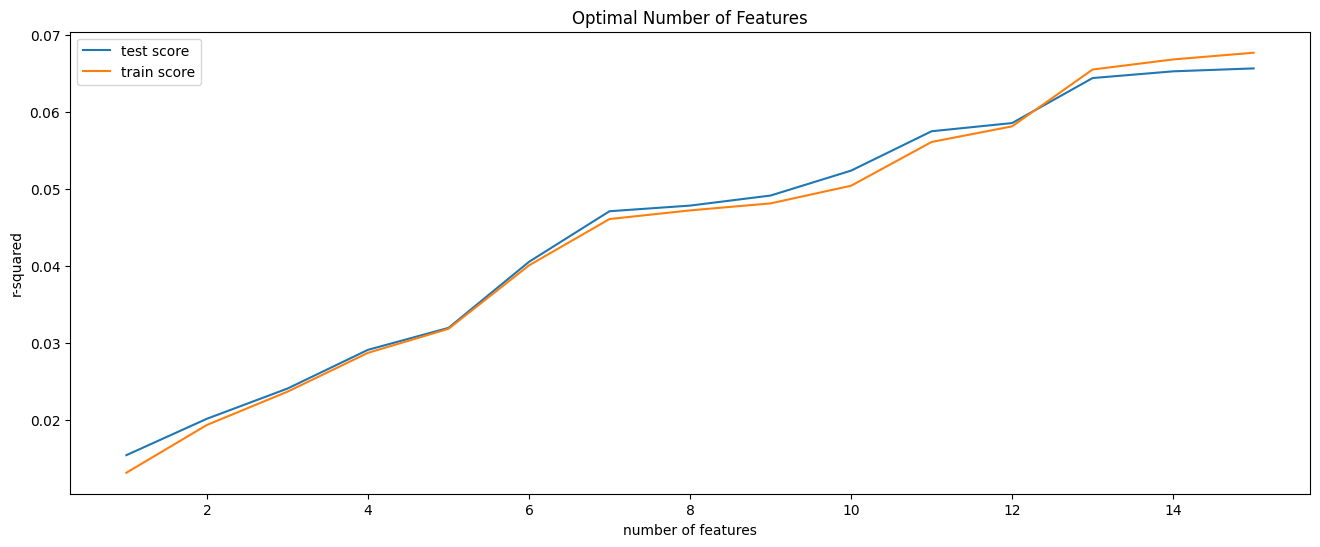

In [181]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Optimal number of features is 13

In [184]:
# final model
n_features_optimal = 13

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2:", r2)
print("mse", mse)

r2: 0.1562938949909739
mse 499.0000544773882


In [149]:
# def standardizacija(x_train, x_test, numeric_feats, dummy_feats):
#     # Save the original order of columns
#     cols = x_train.columns
    
#     # Standardize numeric features
#     s = StandardScaler()
#     s.fit(x_train[numeric_feats])
    
#     x_train_std_numeric = s.transform(x_train[numeric_feats])
#     x_test_std_numeric = s.transform(x_test[numeric_feats])
    
#     x_train_std_numeric = pd.DataFrame(x_train_std_numeric, columns=numeric_feats)
#     x_test_std_numeric = pd.DataFrame(x_test_std_numeric, columns=numeric_feats)

#     # Concatenate standardized numeric features with dummy features
#     x_train_std = pd.concat([x_train_std_numeric, x_train[dummy_feats]], axis=1)
#     x_test_std = pd.concat([x_test_std_numeric, x_test[dummy_feats]], axis=1)

#     return x_train_std_numeric, x_test_std_numeric

## Lasso with poly features

In [185]:
poly = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)
X_inter_train = poly.fit_transform(X_train_std)
X_inter_test = poly.transform(X_test_std)
out_feat_names = PolynomialFeatures.get_feature_names_out(
    poly, input_features=None)

In [151]:
# X_train_std, X_test_std = standardizacija(X_train, X_test, numeric_feats, dummy_feats)
# poly = PolynomialFeatures(interaction_only=False, degree=3, include_bias=False)
# X_inter_train = poly.fit_transform(X_train_std)
# X_inter_test = poly.transform(X_test_std)

/home/srdjan/dev/ml/spotify-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.464e+06, tolerance: 1.952e+03
  model = cd_fast.enet_coordinate_descent(


Mean squared error:  467.33129444313323
Mean absolute error:  17.610422468726025
Root mean squared error:  21.617846665270186
R2 score:  0.2098392321892838
R2 adjusted score:  0.09929007758311359
     y     y_pred
0   42  44.593954
1   64  38.413718
2   40  49.821452
3   41  17.767172
4   27  30.074045
5   55  59.824742
6    0  43.791609
7    0  41.792431
8   40  33.647943
9   50  39.605515
10   1  41.581264
11  32  49.072226
12  67  62.888502
13  63  30.668891
14  53  51.955410
15  42  38.654709
16  53  53.311912
17  80  41.719999
18  62  39.500788
19   2  41.957523
koeficijenti:  [ 0. -0.  0. ...  0.  0. -0.]


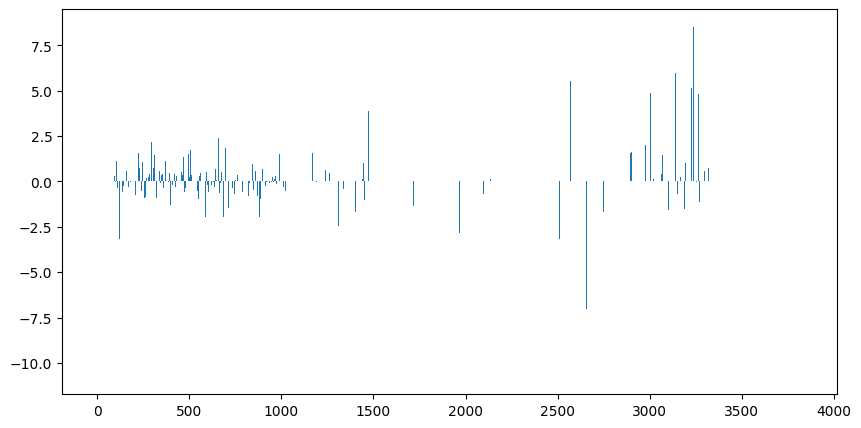

In [152]:
# Inicijalizacija modela
lasso_model_2 = Lasso(alpha=0.01)

#Obuka
lasso_model_2.fit(X_inter_train, y_train)

# Testiranje
y_predicted = lasso_model_2.predict(X_inter_test)

# Evaluacija (racunanje mera uspesnosti)
model_evaluation(y_test, y_predicted, X_inter_train.shape[0], X_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model_2.coef_)),lasso_model_2.coef_)
print("koeficijenti: ", lasso_model_2.coef_)

Mean squared error:  471.32446983465843
Mean absolute error:  17.736193922652998
Root mean squared error:  21.710008517609072
R2 score:  0.20308759674160815
R2 adjusted score:  0.17696278203827986
     y     y_pred
0   42  43.082345
1   64  44.847818
2   40  51.619169
3   41  16.798564
4   27  29.575959
5   55  53.150286
6    0  45.088161
7    0  47.295301
8   40  35.243087
9   50  41.793651
10   1  33.376550
11  32  50.746153
12  67  63.933005
13  63  37.780501
14  53  53.759001
15  42  40.759484
16  53  54.155008
17  80  36.545792
18  62  40.672974
19   2  39.594623
koeficijenti:  [ 0.00000000e+00  4.64959542e+00  7.49583356e+00 -1.53633298e+01
 -3.31226286e+00 -1.74177174e+01  1.90928889e-01 -3.18740580e+00
  1.05738570e+01 -3.99470600e+00  1.40752005e+01  6.27830805e+00
 -8.43368283e-01 -3.77285895e+00 -3.94303343e+00  4.42511832e-02
 -2.83037102e+00  3.71994680e+00  6.78206531e+00 -7.76957584e-01
 -3.11271739e-01  5.47211104e+00  6.95457148e-01 -1.07627685e+00
  5.77360001e-01  1.

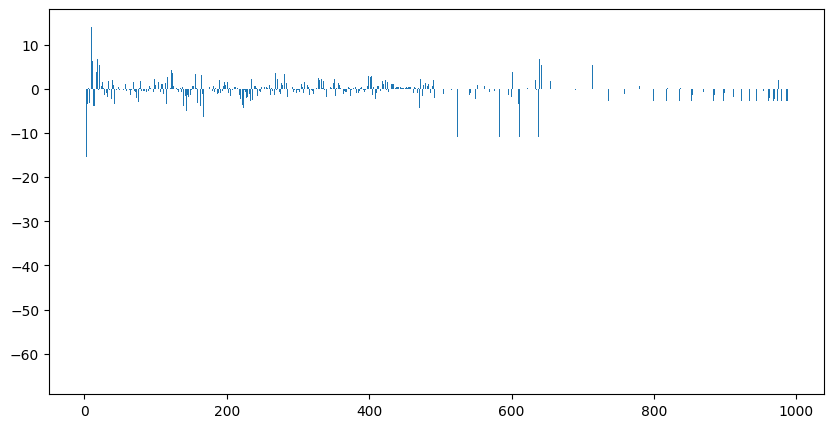

In [186]:
# Inicijalizacija modela
ridge_model = Ridge(alpha=5)

# Obuka
ridge_model.fit(X_inter_train, y_train)

# Testiranje
y_predicted = ridge_model.predict(X_inter_test)

# Evaluacija (racunanje mera uspesnosti)
model_evaluation(y_test, y_predicted,
                 X_inter_train.shape[0], X_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10, 5))
plt.bar(range(len(ridge_model.coef_)), ridge_model.coef_)
print("koeficijenti: ", ridge_model.coef_)

In [187]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

hyper_params = [{'n_features_to_select': list(range(1, 16))}]

ridge = Ridge(alpha=5)
ridge.fit(X_inter_train, y_train)
rfe = RFE(lm)

model_cv = GridSearchCV(
    estimator=rfe,
    param_grid=hyper_params,
    scoring='r2',
    cv=folds,
    verbose=1,
    return_train_score=True
)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15]}],
             return_train_score=True, scoring='r2', verbose=1)